# Import

In [11]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 199)

from datetime import datetime
import re
import os
import os.path
import math
import sys
import csv
import glob
import seaborn as sns
import numpy as np
import shap 
from collections import Counter

# import mlflow
# import mlflow.sklearn
# import pysftp

from sklearn.metrics import confusion_matrix
import seaborn as sns
pd.options.display.float_format = "{:.2f}".format

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm 

import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss, roc_auc_score, f1_score

%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/utils.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/visualization/common_visualization.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/common_eda.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/modelling/regression_model.py"
%run "/Users/chau/minhchau/jupyter_projects/jupyter_project_template-master/src/data_preparation/common_dictionary.py"

print("current working folder: ", os.getcwd())
user_name = "chaupham"
# print("notebook kernel id: ", get_notebook_kernel_id())

current working folder:  /Users/chau/minhchau/jupyter_projects/plant_project


# Helper funcs

In [27]:
def convert_to_up_down_noChange(x, thres, c, base_col):
    if x[c] - x[base_col] > thres:  ##UP
        return "2"
    elif x[c] + thres < x[base_col]:
        return  "1" ## DOWN
    else:
        return "0" # NO_CHANGE

# Read input

In [64]:
df = pd.read_csv("./data/cleaned_data.csv")
df.shape                 

(20450, 14)

In [65]:
df.label.value_counts()

0    19245
1     1205
Name: label, dtype: int64

In [66]:
df.head()

,atID,wthp6,wthp6_2,wtlp6,wtlp6_2,wthp5,wthp5_2,wtlp5,wtlp5_2,wtal,wtal_2,wtfe,wtfe_2,label
0,AT1G01020,18.51,17.60,17.80,20.36,18.99,21.93,18.29,21.48,19.01,17.58,18.21,18.19,0
1,AT1G01030,0.82,1.07,0.68,0.45,0.54,0.40,0.56,0.29,0.22,0.81,0.93,0.62,1
2,AT1G01040,36.57,34.09,31.92,53.51,37.06,34.78,43.44,49.22,42.09,36.11,32.94,17.10,0
3,AT1G01050,103.58,109.89,103.21,96.22,100.88,106.00,97.60,100.95,89.76,92.77,91.97,112.10,0
4,AT1G01060,1.94,1.78,2.93,2.88,3.15,3.67,2.44,2.13,1.34,1.89,3.52,1.89,1


In [67]:
wt_cols = ['wthp6', 'wtlp6',  'wthp5',  'wtlp5',  'wtal',  'wtfe']
wt_conditioned_cols = wt_cols[1:]
base_col= wt_cols[0]
wt_BIT_cols = [c+"_BIT" for c in wt_conditioned_cols]

for c in wt_cols:
    df[c + "_ave"] = (df[c] + df[c + "_2"]) / 2
    
df.columns

Index(['atID', 'wthp6', 'wthp6_2', 'wtlp6', 'wtlp6_2', 'wthp5', 'wthp5_2', 'wtlp5', 'wtlp5_2',
       'wtal', 'wtal_2', 'wtfe', 'wtfe_2', 'label', 'wthp6_ave', 'wtlp6_ave', 'wthp5_ave',
       'wtlp5_ave', 'wtal_ave', 'wtfe_ave'],
      dtype='object')

In [68]:
data_df = df[['atID', 'label', 'wthp6_ave', 'wtlp6_ave', 'wthp5_ave', 'wtlp5_ave', 'wtal_ave', 'wtfe_ave']]
data_df.columns = ['atID', 'label', 'wthp6', 'wtlp6', 'wthp5', 'wtlp5', 'wtal', 'wtfe']

In [69]:
data_df.head()

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe
0,AT1G01020,0,18.06,19.08,20.46,19.88,18.30,18.20
1,AT1G01030,1,0.94,0.57,0.47,0.43,0.52,0.77
2,AT1G01040,0,35.33,42.71,35.92,46.33,39.10,25.02
3,AT1G01050,0,106.73,99.72,103.44,99.28,91.26,102.04
4,AT1G01060,1,1.86,2.91,3.41,2.29,1.61,2.71


In [73]:
def get_L1_raw(x):
    return sum(np.abs([x[c] - x[base_col] for c in wt_conditioned_cols]))
    
def get_L2_raw(x):
    return math.sqrt(np.square([x[c] - x[base_col] for c in wt_conditioned_cols]))
    
def get_L1_norm(x):
    max_x = np.amax(x[wt_cols])
    x[wt_cols] = x[wt_cols]/max_x
    return get_L1_raw(x)

def get_L2_norm(x):
    max_x = np.amax(x[wt_cols])
    x[wt_cols] = x[wt_cols]/max_x
    return get_L2_raw(x)

def get_L1_Log2Fold(x):
    return sum(np.abs( np.log2([x[c] / x[base_col] for c in wt_conditioned_cols])) )

def get_L2_Log2Fold(x):
    return np.sum(np.square( np.log2([x[c] / x[base_col] for c in wt_conditioned_cols])) )

# Filter out wthp6==0

In [74]:
tmp = data_df[data_df['wthp6'] == 0]
print(f"Shape before removing: {df.shape[0]};\nThere is {tmp.shape[0]} obs having wthp6==0, in which {tmp[tmp.label == 1].shape[0]} are class_1")
data_df = data_df[data_df['wthp6'] != 0]
data_df.shape

Shape before removing: 20450;
There is 0 obs having wthp6==0, in which 0 are class_1


(20412, 9)

In [75]:
data_df["L1_log2fold"] = data_df.apply(get_L1_Log2Fold, 1)
data_df["L2_log2fold"] = data_df.apply(get_L2_Log2Fold, 1)

data_df.head()

,atID,label,wthp6,wtlp6,wthp5,wtlp5,wtal,wtfe,L1_log2fold,L2_log2fold
0,AT1G01020,0,18.06,19.08,20.46,19.88,18.30,18.20,0.43,0.06
1,AT1G01030,1,0.94,0.57,0.47,0.43,0.52,0.77,4.02,3.66
2,AT1G01040,0,35.33,42.71,35.92,46.33,39.10,25.02,1.33,0.50
3,AT1G01050,0,106.73,99.72,103.44,99.28,91.26,102.04,0.54,0.08
4,AT1G01060,1,1.86,2.91,3.41,2.29,1.61,2.71,2.57,1.61


In [76]:
data_df.label.value_counts()

0    19209
1     1203
Name: label, dtype: int64

In [77]:
data_df.shape

(20412, 10)

# Run with a threshold

In [148]:
thres = 0.1

for c in wt_conditioned_cols:
    data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange(x, thres, c, base_col), 1)

data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
stats_data_df

,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,#genes,#TF(s),%TF
0,1,1,1,1,1,2645,123,4.65
1,2,2,2,2,2,2407,153,6.36
2,2,2,2,2,1,1740,91,5.23
3,1,1,1,1,2,1497,42,2.81
4,1,1,1,2,2,703,51,7.25
5,1,2,2,2,2,667,49,7.35
6,2,1,1,1,1,629,29,4.61
7,2,2,2,1,1,568,48,8.45
8,2,1,2,2,1,465,17,3.66
9,2,2,2,1,2,434,31,7.14


In [149]:
stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
# stats_data_df.head()

In [150]:
data_df_class_1_only = data_df[data_df.label == 1]
stats_class_1_only = data_df_class_1_only[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
stats_class_1_only

,wtlp6_BIT,wthp5_BIT,wtlp5_BIT,wtal_BIT,wtfe_BIT,#genes,#TF(s)
0,2,2,2,2,2,153,153
1,1,1,1,1,1,123,123
2,2,2,2,2,1,91,91
3,1,1,1,2,2,51,51
4,1,2,2,2,2,49,49
5,2,2,2,1,1,48,48
6,1,1,1,1,2,42,42
7,1,1,1,2,1,32,32
8,2,2,2,1,2,31,31
9,2,1,1,1,1,29,29


In [ ]:
unique_groups = stats_data_df.group_id
DataFrameDict = dict()
summary = dict()
# sort_cols = ["L1_raw", "L2_raw", "L1_norm", "L2_norm"]
sort_cols = ["L1_log2fold", "L2_log2fold"]

interesting_cols = ['atID', 'label'] + wt_cols + sort_cols


for sort_col in sort_cols:
    summary[sort_col] = dict()
    summary[sort_col]["num_tf"] = list()
    summary[sort_col]["percent_tf"] = list()
    summary[sort_col]["auc"] = list()
    
   
    
for key in unique_groups:
    DataFrameDict[key] = dict()
    DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
    DataFrameDict[key]["result"] = dict()
    
    for sort_col in sort_cols:
        DataFrameDict[key]["result"][sort_col] = dict()
        tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
        total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
        num_tf_candidates_in_the_top = tmp.head(total_tf_candidates)["label"].sum()
        percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
        try:
            auc = roc_auc_score(tmp.label, tmp[sort_col].replace(np.inf, 9999))
            summary[sort_col]["auc"].append(auc)
            DataFrameDict[key]["result"][sort_col]['auc'] = auc
            
        except:
            auc = np.nan
            summary[sort_col]["auc"].append(auc)
            DataFrameDict[key]["result"][sort_col]['auc'] = auc

        summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
        summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)
        
        DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
        DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
        

In [ ]:
print("THRESHOLD = ", thres)
for sort_col in sort_cols:
    print("\t", sort_col)
    for key,val in summary[sort_col].items():
        print(f"{key}, {val}, sum is {np.nansum(val)}, mean is {np.nanmean(val)}", end="\n\n")
        
#         print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
    
    print("\t\t---")
print("=============")

In [ ]:
for sort_col in sort_cols:
    stats_data_df[sort_col + "_num_tf"] = summary[sort_col]["num_tf"]
    stats_data_df[sort_col + "_auc"] = summary[sort_col]["auc"]

    print(sort_col, "num_tf:", np.nanmedian ( stats_data_df[sort_col + "_num_tf"].sum()) )
    print(sort_col, "average auc:",np.nanmedian(stats_data_df[sort_col + "_auc"] ) )
    print("-----")

stats_data_df

# Run with many thresholds

In [138]:
def run_all(thres_list):
    summary_ALL = {}
    short_res = {}
    
    for sort_col in sort_cols:
        short_res[sort_col] = []
    
    for thres in thres_list:
        for c in wt_conditioned_cols:
            data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange(x, thres, c, base_col), 1)

        data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

        stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
        stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
        stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
        
    
        
        unique_groups = stats_data_df.group_id
        DataFrameDict = dict()
        summary = dict()

        for sort_col in sort_cols:
            summary[sort_col] = dict()
            summary[sort_col]["num_tf"] = list()
            summary[sort_col]["percent_tf"] = list()
            summary[sort_col]["auc"] = list()


        for key in unique_groups:
            DataFrameDict[key] = dict()
            DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
            DataFrameDict[key]["result"] = dict()

            for sort_col in sort_cols:
                DataFrameDict[key]["result"][sort_col] = dict()
                tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
                total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
                num_tf_candidates_in_the_top = tmp.head(total_tf_candidates)["label"].sum()
                percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
                try:
                    auc = roc_auc_score(tmp.label, tmp[sort_col].replace(np.inf, 9999))
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                except:
                    auc = np.nan
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
                summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)

#                 DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
#                 DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
                
        summary_ALL[thres] = summary
        print("THRESHOLD = ", thres)
        for sort_col in sort_cols:
            print("\t", sort_col)
            for key,val in summary[sort_col].items():
                print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
                
            short_res[sort_col].append(sum(summary[sort_col]["num_tf"]))

            print("\t\t---")
        print("=============")
    return summary_ALL, short_res

In [139]:
thres_list = np.arange(0, 5, 0.1)
summary_ALL_, short_res_ = run_all(thres_list)
short_res_

THRESHOLD =  0.0
	 L1_log2fold
		 num_tf: sum is 59, mean is 1.84375
		 percent_tf: sum is 171.62, mean is 5.363125
		 auc: sum is 17.2112830310822, mean is 0.5378525947213187
		---
	 L2_log2fold
		 num_tf: sum is 65, mean is 2.03125
		 percent_tf: sum is 179.39999999999998, mean is 5.606249999999999
		 auc: sum is 17.23798869802614, mean is 0.5386871468133169
		---
THRESHOLD =  0.1
	 L1_log2fold
		 num_tf: sum is 75, mean is 0.3125
		 percent_tf: sum is 1360.32, mean is 9.512727272727272
		 auc: sum is 74.52406762927514, mean is 0.5248173776709517
		---
	 L2_log2fold
		 num_tf: sum is 84, mean is 0.35
		 percent_tf: sum is 1475.23, mean is 10.316293706293706
		 auc: sum is 74.45733649440179, mean is 0.524347440101421
		---
THRESHOLD =  0.2
	 L1_log2fold
		 num_tf: sum is 73, mean is 0.3004115226337449
		 percent_tf: sum is 1447.65, mean is 7.95412087912088
		 auc: sum is 96.87031507397789, mean is 0.53225447842845
		---
	 L2_log2fold
		 num_tf: sum is 76, mean is 0.31275720164609055
	

THRESHOLD =  2.0
	 L1_log2fold
		 num_tf: sum is 69, mean is 0.2875
		 percent_tf: sum is 919.71, mean is 5.71248447204969
		 auc: sum is 90.60458805843294, mean is 0.5627614165120058
		---
	 L2_log2fold
		 num_tf: sum is 78, mean is 0.325
		 percent_tf: sum is 1074.9499999999998, mean is 6.676708074534161
		 auc: sum is 89.75084291932578, mean is 0.5574586516728309
		---
THRESHOLD =  2.1
	 L1_log2fold
		 num_tf: sum is 72, mean is 0.3025210084033613
		 percent_tf: sum is 882.6, mean is 5.657692307692308
		 auc: sum is 88.79767741475442, mean is 0.5728882413855124
		---
	 L2_log2fold
		 num_tf: sum is 80, mean is 0.33613445378151263
		 percent_tf: sum is 1045.12, mean is 6.699487179487178
		 auc: sum is 86.84105016223413, mean is 0.5602648397563492
		---
THRESHOLD =  2.2
	 L1_log2fold
		 num_tf: sum is 73, mean is 0.3080168776371308
		 percent_tf: sum is 908.03, mean is 5.93483660130719
		 auc: sum is 85.7806252537249, mean is 0.564346218774506
		---
	 L2_log2fold
		 num_tf: sum is 78,

THRESHOLD =  4.0
	 L1_log2fold
		 num_tf: sum is 66, mean is 0.28695652173913044
		 percent_tf: sum is 1225.42, mean is 10.127438016528926
		 auc: sum is 64.86031263516546, mean is 0.5360356416129377
		---
	 L2_log2fold
		 num_tf: sum is 69, mean is 0.3
		 percent_tf: sum is 1091.83, mean is 9.023388429752066
		 auc: sum is 64.83202873178632, mean is 0.5358018903453415
		---
THRESHOLD =  4.1000000000000005
	 L1_log2fold
		 num_tf: sum is 69, mean is 0.3
		 percent_tf: sum is 1381.04, mean is 11.32
		 auc: sum is 64.96169331550311, mean is 0.5368734984752324
		---
	 L2_log2fold
		 num_tf: sum is 69, mean is 0.3
		 percent_tf: sum is 1146.88, mean is 9.40065573770492
		 auc: sum is 65.04579096490889, mean is 0.5375685203711479
		---
THRESHOLD =  4.2
	 L1_log2fold
		 num_tf: sum is 67, mean is 0.2925764192139738
		 percent_tf: sum is 1254.8600000000001, mean is 10.545042016806724
		 auc: sum is 63.355793194662375, mean is 0.5369135016496811
		---
	 L2_log2fold
		 num_tf: sum is 67, mean i

{'L1_log2fold': [59,
  75,
  73,
  66,
  73,
  79,
  77,
  75,
  70,
  67,
  67,
  71,
  77,
  73,
  65,
  65,
  71,
  68,
  70,
  71,
  69,
  72,
  73,
  77,
  76,
  75,
  73,
  70,
  68,
  71,
  70,
  72,
  70,
  69,
  64,
  65,
  66,
  66,
  70,
  69,
  66,
  69,
  67,
  65,
  68,
  68,
  66,
  65,
  62,
  63],
 'L2_log2fold': [65,
  84,
  76,
  69,
  75,
  84,
  82,
  81,
  76,
  67,
  72,
  69,
  73,
  67,
  69,
  73,
  74,
  72,
  78,
  80,
  78,
  80,
  78,
  82,
  82,
  79,
  73,
  71,
  74,
  73,
  75,
  75,
  73,
  74,
  69,
  69,
  71,
  74,
  76,
  73,
  69,
  69,
  67,
  68,
  72,
  70,
  69,
  67,
  64,
  65]}

In [140]:
for k, v in short_res_.items():
    print(k, np.amax(v))

L1_log2fold 79
L2_log2fold 84


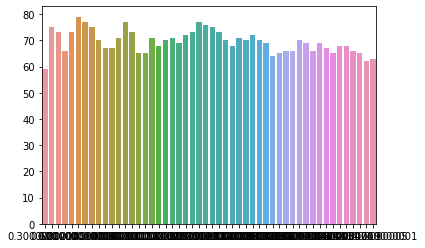

In [141]:
sns.barplot(x=thres_list, y=short_res_["L1_log2fold"])

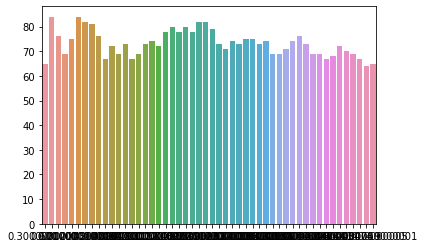

In [146]:
sns.barplot(x=thres_list, y=short_res_["L2_log2fold"])

# Run many thresholds with leader percent

In [142]:
def run_all_with_percent(thres_list, leader_percent):
    summary_ALL = {}
    short_res = {}
    
    for sort_col in sort_cols:
        short_res[sort_col] = []
    
    for thres in thres_list:
        for c in wt_conditioned_cols:
            data_df[c+"_BIT"] = data_df.apply(lambda x: convert_to_up_down_noChange(x, thres, c, base_col), 1)

        data_df["group_id"] = data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)

        stats_data_df = data_df[wt_BIT_cols + ["atID", "label"]].groupby(wt_BIT_cols).agg({"atID": np.size, "label": np.sum}).reset_index().sort_values("atID", ascending= False).reset_index(drop=True).rename(columns = {"atID": "#genes", "label":"#TF(s)"})
        stats_data_df["%TF"] = np.round(stats_data_df["#TF(s)"] * 100/stats_data_df["#genes"],2)
        stats_data_df["group_id"] = stats_data_df[wt_BIT_cols].apply(lambda x: "".join(x[c] for c in wt_BIT_cols),1)
        
    
        
        unique_groups = stats_data_df.group_id
        DataFrameDict = dict()
        summary = dict()

        for sort_col in sort_cols:
            summary[sort_col] = dict()
            summary[sort_col]["num_tf"] = list()
            summary[sort_col]["percent_tf"] = list()
            summary[sort_col]["auc"] = list()


        for key in unique_groups:
            DataFrameDict[key] = dict()
            DataFrameDict[key]["data"] = data_df[data_df.group_id == key].loc[:, interesting_cols]
            DataFrameDict[key]["result"] = dict()

            for sort_col in sort_cols:
                DataFrameDict[key]["result"][sort_col] = dict()
                tmp = DataFrameDict[key]["data"].sort_values(sort_col, ascending=True)
#                 total_tf_candidates =  stats_data_df[stats_data_df.group_id == key]["#TF(s)"].values[0]
                num_tf_to_take = int(tmp.shape[0] * leader_percent) ## get x percent
                num_tf_candidates_in_the_top = tmp.head(num_tf_to_take)["label"].sum()
                percent_tf_candidates_in_the_top = np.round(num_tf_candidates_in_the_top*100/total_tf_candidates,2)
                try:
                    auc = roc_auc_score(tmp.label, tmp[sort_col].replace(np.inf, 9999))
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                except:
                    auc = np.nan
                    summary[sort_col]["auc"].append(auc)
                    DataFrameDict[key]["result"][sort_col]['auc'] = auc

                summary[sort_col]["num_tf"].append(num_tf_candidates_in_the_top)
                summary[sort_col]["percent_tf"].append(percent_tf_candidates_in_the_top)

#                 DataFrameDict[key]["result"][sort_col]['num_tf'] = num_tf_candidates_in_the_top
#                 DataFrameDict[key]["result"][sort_col]['percent_tf'] = percent_tf_candidates_in_the_top
                
        summary_ALL[thres] = summary
        print("THRESHOLD = ", thres)
        for sort_col in sort_cols:
            print("\t", sort_col)
            for key,val in summary[sort_col].items():
                print(f"\t\t {key}: sum is {np.nansum(val, )}, mean is {np.nanmean(val)}", end="\n")
                
            short_res[sort_col].append(sum(summary[sort_col]["num_tf"]))

            print("\t\t---")
        print("=============")
    return summary_ALL, short_res

In [143]:
leader_percent = 0.05
summary_ALL_with_percent, short_res_with_percent = run_all_with_percent(thres_list, leader_percent)
short_res_with_percent

THRESHOLD =  0.0
	 L1_log2fold
		 num_tf: sum is 47, mean is 1.46875
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 17.2112830310822, mean is 0.5378525947213187
		---
	 L2_log2fold
		 num_tf: sum is 51, mean is 1.59375
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 17.23798869802614, mean is 0.5386871468133169
		---
THRESHOLD =  0.1
	 L1_log2fold
		 num_tf: sum is 45, mean is 0.1875
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 74.52406762927514, mean is 0.5248173776709517
		---
	 L2_log2fold
		 num_tf: sum is 53, mean is 0.22083333333333333
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 74.45733649440179, mean is 0.524347440101421
		---
THRESHOLD =  0.2
	 L1_log2fold
		 num_tf: sum is 41, mean is 0.16872427983539096
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 96.87031507397789, mean is 0.53225447842845
		---
	 L2_log2fold
		 num_tf: sum is 39, mean is 0.16049382716049382
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 96.76732503402721, mea

THRESHOLD =  2.2
	 L1_log2fold
		 num_tf: sum is 38, mean is 0.16033755274261605
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 85.7806252537249, mean is 0.564346218774506
		---
	 L2_log2fold
		 num_tf: sum is 38, mean is 0.16033755274261605
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 84.19251985154945, mean is 0.5538981569180885
		---
THRESHOLD =  2.3000000000000003
	 L1_log2fold
		 num_tf: sum is 43, mean is 0.18143459915611815
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 83.59468338410731, mean is 0.5648289417845088
		---
	 L2_log2fold
		 num_tf: sum is 40, mean is 0.16877637130801687
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 82.48310777694928, mean is 0.5573182957901979
		---
THRESHOLD =  2.4000000000000004
	 L1_log2fold
		 num_tf: sum is 39, mean is 0.16595744680851063
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 83.33418668770335, mean is 0.56689922916805
		---
	 L2_log2fold
		 num_tf: sum is 41, mean is 0.17446808510638298
		 percen

THRESHOLD =  4.4
	 L1_log2fold
		 num_tf: sum is 39, mean is 0.17333333333333334
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 60.83013972534962, mean is 0.5335977168890317
		---
	 L2_log2fold
		 num_tf: sum is 44, mean is 0.19555555555555557
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 61.16731745342799, mean is 0.5365554162581403
		---
THRESHOLD =  4.5
	 L1_log2fold
		 num_tf: sum is 39, mean is 0.17488789237668162
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 60.03069252069665, mean is 0.5265850221113741
		---
	 L2_log2fold
		 num_tf: sum is 42, mean is 0.18834080717488788
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 60.523533126707704, mean is 0.5309081853219975
		---
THRESHOLD =  4.6000000000000005
	 L1_log2fold
		 num_tf: sum is 40, mean is 0.17857142857142858
		 percent_tf: sum is inf, mean is inf
		 auc: sum is 58.417005538192655, mean is 0.5215804065910058
		---
	 L2_log2fold
		 num_tf: sum is 42, mean is 0.1875
		 percent_tf: sum is inf, mean

{'L1_log2fold': [47,
  45,
  41,
  37,
  34,
  41,
  44,
  46,
  40,
  44,
  46,
  40,
  42,
  39,
  40,
  36,
  38,
  33,
  34,
  34,
  34,
  35,
  38,
  43,
  39,
  40,
  39,
  38,
  39,
  40,
  38,
  37,
  39,
  39,
  37,
  37,
  37,
  39,
  40,
  38,
  37,
  37,
  37,
  37,
  39,
  39,
  40,
  38,
  40,
  38],
 'L2_log2fold': [51,
  53,
  39,
  36,
  37,
  42,
  41,
  47,
  48,
  50,
  48,
  41,
  42,
  43,
  42,
  38,
  38,
  35,
  37,
  35,
  36,
  36,
  38,
  40,
  41,
  41,
  40,
  40,
  43,
  41,
  41,
  41,
  39,
  41,
  42,
  42,
  40,
  41,
  40,
  41,
  40,
  41,
  41,
  41,
  44,
  42,
  42,
  40,
  40,
  41]}

In [147]:
for k, v in short_res_with_percent.items():
    print(k, np.amax(v))

L1_log2fold 47
L2_log2fold 53


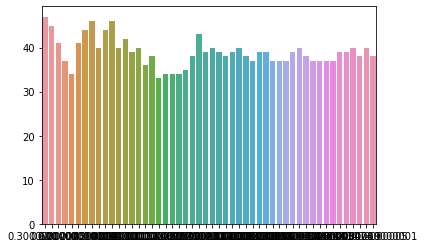

In [145]:
sns.barplot(x=thres_list, y=short_res_with_percent["L2_log2fold"])